# Impact of Social Factors on Salary

Our expectation for this analysis is to identify any potential discrimination towards different genders and different races.

## Importing Relevant Packages and Datasets

In [1]:
import findspark
findspark.init()

In [2]:
import numpy as np
import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import *
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, to_timestamp, unix_timestamp, to_date, to_date, col, year, month

In [3]:
spark = pyspark.sql.SparkSession.builder.master("local").getOrCreate()

In [4]:
# Let's define our schema
schema = StructType([\
    StructField("date", DateType(), True),\
    StructField("time", StringType(), True),\
    StructField("company", StringType(), True),\
    StructField("level", StringType(), True),\
    StructField("title", StringType(), True),\
    StructField("totalyearlycompensation", IntegerType(), False),\
    StructField("location", StringType(), True),\
    StructField("yearsofexperience", FloatType(), False),\
    StructField("yearsatcompany", FloatType(), False),\
    StructField("tag", StringType(), True),\
    StructField("basesalary", IntegerType(), False),\
    StructField("stockgrantvalue", IntegerType(), False),\
    StructField("bonus", IntegerType(), False),\
    StructField("gender", StringType(), True),\
    StructField("cityid", StringType(), True),\
    StructField("dmaid", StringType(), True),\
    StructField("race", StringType(), True),\
    StructField("education", StringType(), True)])

# Load and parse the data file, converting it to a DataFrame.
data = spark.read.format("csv")\
    .option("header", "false")\
    .option("delimiter", "\t")\
    .schema(schema)\
    .load("../data/seperated_time_data/cleaned.txt")

# Short Analysis by Gender

In [5]:
# Filtering dataset where gender is null/invalid
filtered_data = data.filter(data["gender"].isin(["Male", "Female", "Other"]))

In [6]:
# show how many of each gender are present in the group
filtered_data.groupby("gender").count().show()

+------+-----+
|gender|count|
+------+-----+
|Female| 6999|
| Other|  400|
|  Male|35702|
+------+-----+



In [7]:
# Grouping the data on 'gender' and calculating the average basesalary
salary_per_gender = filtered_data.groupby("gender").mean("basesalary")

# Rounding the average base salary to 2 decimal places
rounded_avg_salary_per_gender = salary_per_gender.withColumn("avg(basesalary)", F.round(salary_per_gender["avg(basesalary)"], 2))
rounded_avg_salary_per_gender.show()

+------+---------------+
|gender|avg(basesalary)|
+------+---------------+
|Female|      136986.15|
| Other|      150273.96|
|  Male|      139522.83|
+------+---------------+



In [8]:
# Grouping the data on 'gender' and calculating the average bonus
bonus_per_gender = filtered_data.groupby("gender").mean("bonus")

# Rounding the average bonus to 2 decimal places
rounded_avg_bonus_per_gender = bonus_per_gender.withColumn("avg(bonus)", F.round(bonus_per_gender["avg(bonus)"], 2))
rounded_avg_bonus_per_gender.show()

+------+----------+
|gender|avg(bonus)|
+------+----------+
|Female|  17200.59|
| Other|   23435.0|
|  Male|  19395.31|
+------+----------+



# Short Analysis by Ethnicity

In [9]:
# Filtering the dataset where race is null
filtered_ethnic_data = data.filter(data["race"]!="NA")

In [10]:
# Grouping the data on 'race' and calculating the average base salary
salary_per_race = filtered_ethnic_data.groupby('race').mean('basesalary')

# Rounding the average base salary to 2 decimal places
rounded_avg_salary_per_race = salary_per_race.withColumn("avg(basesalary)", F.round(salary_per_race["avg(basesalary)"], 2))
rounded_avg_salary_per_race.show()

+-----------+---------------+
|       race|avg(basesalary)|
+-----------+---------------+
|Two Or More|      137812.19|
|      White|      139939.49|
|      Black|      131549.28|
|   Hispanic|      132629.76|
|      Asian|      129829.17|
+-----------+---------------+



In [11]:
# Grouping the data on 'race' and calculating the average bonus
bonus_per_race = filtered_ethnic_data.groupby("race").mean("bonus")

# Rounding the average bonus to 2 decimal places
rounded_avg_bonus_per_race = bonus_per_race.withColumn("avg(bonus)", F.round(bonus_per_race["avg(bonus)"], 2))
rounded_avg_bonus_per_race.show()

+-----------+----------+
|       race|avg(bonus)|
+-----------+----------+
|Two Or More|  19751.24|
|      White|  18790.21|
|      Black|  18313.04|
|   Hispanic|  17957.48|
|      Asian|  18054.45|
+-----------+----------+



## Creating new Column for Month/Year to allow for Grouping

In [12]:
adjusted_data_1 = data.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))\
    .withColumn('month', month("date"))

adjusted_data_2 = adjusted_data_1.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))\
    .withColumn('year', year("date"))

In [13]:
new_data = adjusted_data_2.select('year', 'month', 'gender', 'race', 'basesalary')

In [14]:
# Combining the columns 'month' and 'year' to a column of DateType()
date_data = new_data.withColumn(
    "date",
    F.date_format(F.expr("make_date(year, month, 1)"), "MM/dd/yyyy")
)

## Plotting Average Salaries per Gender grouped by Month

In [15]:
# Filtering dataset where gender is null/invalid
filtered_data = date_data.filter(data["gender"].isin(["Male", "Female", "Other"]))

In [16]:
# Grouping the data on 'gender' and calculating the average basesalary
salary_per_gender = filtered_data.groupby("date", "gender").mean("basesalary")

# Rounding the average base salary to 2 decimal places
rounded_avg_salary_per_gender = salary_per_gender.withColumn("avg(basesalary)", F.round(salary_per_gender["avg(basesalary)"], 2))

In [17]:
# Converting the date column to DateType()
clean_date = rounded_avg_salary_per_gender.select(to_date(col("date"),"MM/dd/yyyy").alias("date"), "gender", "avg(basesalary)")

In [18]:
# Separating the gender data into separate Pandas Dataframes
female_salary = clean_date.filter(data["gender"]=="Female").toPandas()
male_salary = clean_date.filter(data["gender"]=="Male").toPandas()
othergender_salary = clean_date.filter(data["gender"]=="Other").toPandas()

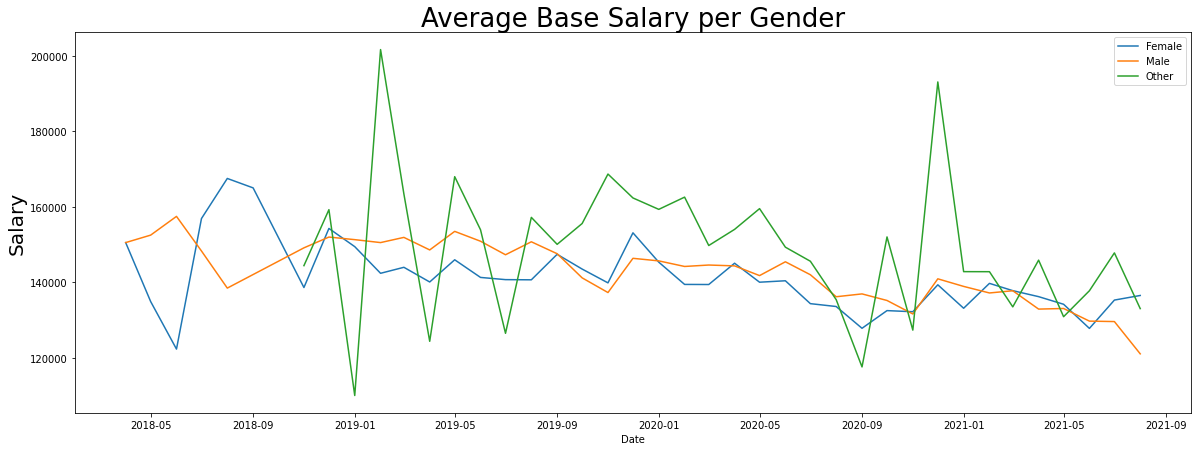

In [261]:
# Plotting each of the genders' average base salary
fig, ax = plt.subplots(figsize=(20, 7))
female_salary.plot(x="date", ax=ax, legend="Female")
male_salary.plot(x="date", ax=ax, legend="Male")
othergender_salary.plot(x="date", ax=ax, legend="Other")
plt.title("Average Base Salary per Gender", fontsize=26)
plt.xlabel("Date")
plt.ylabel("Salary", fontsize=20)
plt.legend(labels=["Female", "Male", "Other"], loc='best')
plt.show()

The gender with the most variance in average base salary is 'Other', this could be explained by the fact that this gender is underrepresented in the dataset, making up less than 1% of employees. We also notice that there is very little difference in the average salaries between males and females. This could be as a result of the introduction of the Employment Equality Acts, which combats gender pay gaps.

## Plotting Average Salaries per Gender grouped by Day

In [19]:
# Filtering out null gender values
filtered_data = data.filter(data["gender"].isin(["Male", "Female", "Other"]))

# Grouping by date and gender, and calculating the average salary
grouped_data = filtered_data.groupby('date', 'gender').mean('basesalary')

# Rounding the average base salary to 2 decimal places
rounded_data = grouped_data.withColumn("avg(basesalary)", F.round(grouped_data["avg(basesalary)"], 2))

In [20]:
# Separating the gender data into separate Pandas Dataframes
female_salary = rounded_data.filter(data["gender"]=="Female").toPandas()
male_salary = rounded_data.filter(data["gender"]=="Male").toPandas()
othergender_salary = rounded_data.filter(data["gender"]=="Other").toPandas()

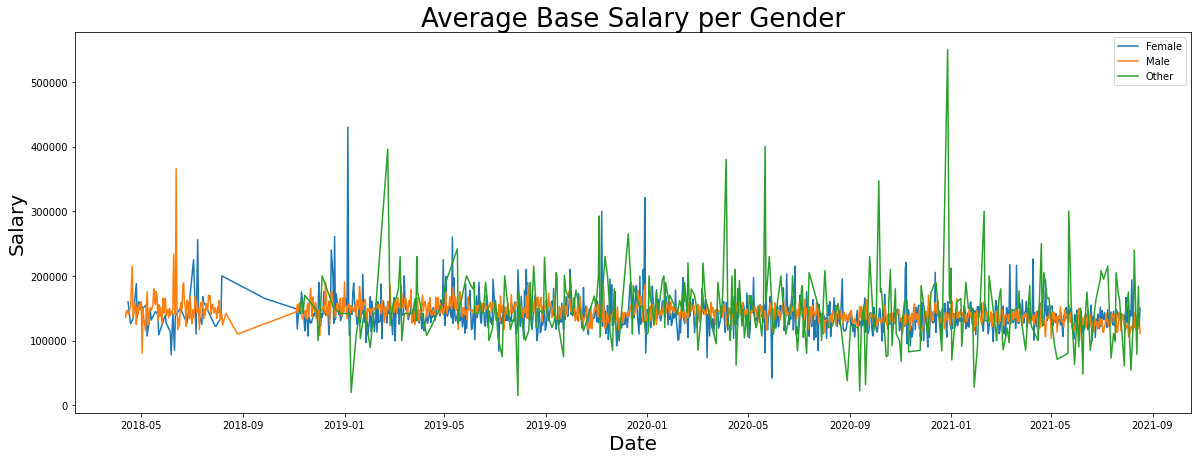

In [265]:
# Plotting the average salary per gender for each day
fig, ax = plt.subplots(figsize=(20, 7))
female_salary.plot(x="date", ax=ax, legend="Female")
male_salary.plot(x="date", ax=ax, legend="Male")
othergender_salary.plot(x="date", ax=ax, legend="Other")
plt.title("Average Base Salary per Gender", fontsize=26)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Salary", fontsize=20)
plt.legend(labels=["Female", "Male", "Other"], loc='best')
plt.show()

More prominent spikes for the gender "other", this could be due to the small number of employees that are of this gender. As the data is grouped by day (less of each gender in a grouping), this has shown that large salaries achieved by underrepresented genders are more obvious in the graph. 

## Plotting Average Salaries per Race

In [21]:
# Filtering dataset to exclude null values
filtered_data = date_data.filter(data["race"]!="NA")

# Grouping by date and race, and calculating average salary
salary_per_race = filtered_data.groupby("date", "race").mean("basesalary")

# Rounding average salary to 2 decimal places
rounded_data = salary_per_race.withColumn("avg(basesalary)", F.round(salary_per_race["avg(basesalary)"], 2))

In [22]:
# Converting the date column to DateType()
clean_date = rounded_data.select(to_date(col("date"),"MM/dd/yyyy").alias("date"), "race", "avg(basesalary)")

In [23]:
# Creating separate datasets for each race
two_salary = clean_date.filter(data["race"]=="Two Or More").toPandas()
white_salary = clean_date.filter(data["race"]=="White").toPandas()
black_salary = clean_date.filter(data["race"]=="Black").toPandas()
hispanic_salary = clean_date.filter(data["race"]=="Hispanic").toPandas()
asian_salary = clean_date.filter(data["race"]=="Asian").toPandas()

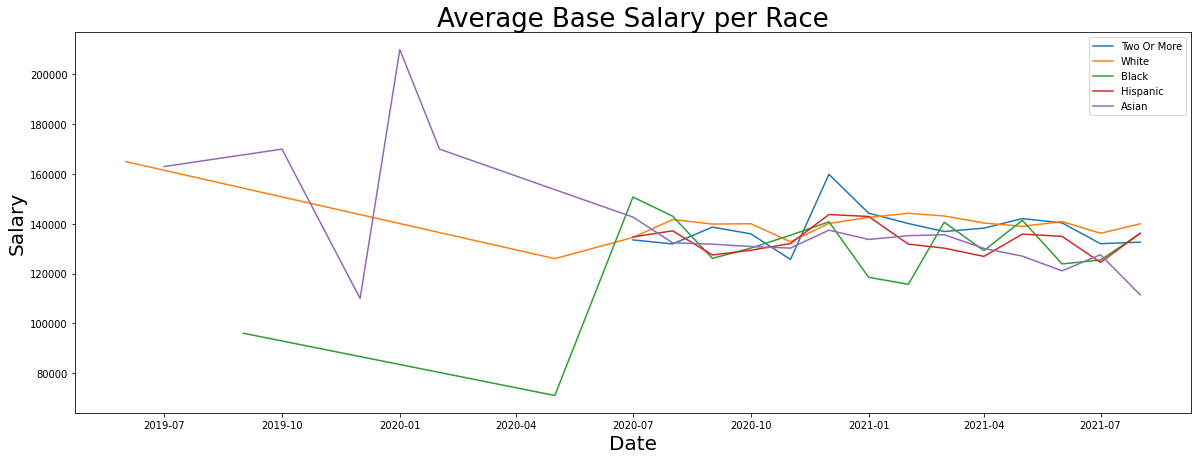

In [270]:
# Plotting each race's average base salary
fig, ax = plt.subplots(figsize=(20, 7))
two_salary.plot(x="date", ax=ax)
white_salary.plot(x="date", ax=ax)
black_salary.plot(x="date", ax=ax)
hispanic_salary.plot(x="date", ax=ax)
asian_salary.plot(x="date", ax=ax)
plt.title("Average Base Salary per Race", fontsize=26)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Salary", fontsize=20)
plt.legend(labels=["Two Or More", "White", "Black", "Hispanic", "Asian"], loc='best')
plt.show()

Judging from the average salaries tracked from July 2020 onwards it seems that there is very little differences between base salary for each race. However, the graph shows that white people earn consistently higher than that of black people, although the difference is minor and may be explained by company/position differences.

## Identifying Gender Differences per Job Position 

In [24]:
# Finding the top 10 most common job titles in the dataset and assigning them in a list
all_titles = data.groupby("title").count()
all_titles.sort(col("count").desc())
most_common_titles = all_titles.sort(col("count").desc()).limit(10)
most_common_titles_list = most_common_titles.rdd.map(lambda x: x[0]).collect()

In [25]:
# Grouping data by job title and gender, and calculating the average base salary
grouped_data = data.groupby('title', 'gender').mean('basesalary')

In [26]:
# Filtering the data to only look at the top 10 most common positions, and converting it to a Pandas dataframe
filtered_data = grouped_data.filter(grouped_data['title'].isin(most_common_titles_list)).toPandas()

In [27]:
# Reassigning the title values as integers for easier graphing
titles_dict = {}
for index in range(1, 11):
    titles_dict[most_common_titles_list[index-1]] = index
    
# Applying this change to the pandas dataframe
filtered_data['title'] = filtered_data['title'].replace(titles_dict)

In [28]:
# Creating separate datasets for each gender
female_data = filtered_data[filtered_data['gender']=="Female"]
male_data = filtered_data[filtered_data['gender']=="Male"]
other_data = filtered_data[filtered_data['gender']=="Other"]

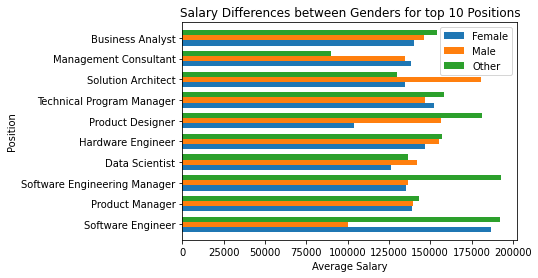

In [30]:
# Plotting a horizontal bar chart for average base salary by position
ind = np.arange(10)
width = 0.25

fig, ax = plt.subplots()
ax.barh(ind, female_data['avg(basesalary)'], width, label='Female')
ax.barh(ind + width, male_data['avg(basesalary)'], width, label='Male')
ax.barh(ind + (2*width), other_data['avg(basesalary)'], width, label='Other')

ax.set(yticks=ind + width, 
       yticklabels=most_common_titles_list, 
       ylim=[2*width - 1, len(most_common_titles_list)],
      title="Salary Differences between Genders for top 10 Positions",
      xlabel="Average Salary",
      ylabel="Position")
ax.legend();

This graph shows that for the majority of roles, such as Product Manager and Technical Program Manager, there is very little difference in salaries for each gender. There are large differences, however, for some other roles. These differences do not favour any particular gender, and seem to be quite varied. For example, male employees are shown to earn significantly more in the role of a Solution Architect, and significantly less in the role of a Software Engineer. There are also some roles where the genders 'Female' and 'Other' achieve much larger/smaller salaries for the same role. This suggests that there is a natural distribution of salaries among genders.